# **Avance 4 · Modelos Alternativos**
**Fecha:** 2025-10-19 19:35
Curso: TC5035 - Proyecto Integrador

Tecnológico de Monterrey

Prof Horacio Martínez Alfaro

Módulo 3 Ingeniería y evaluación de modelos

Equipo 18

Joaquín Díaz Hernández - A01281536

Divad Alejandro Shriqui Garrón - A01366907

Manuel Romero Alvarez - A00567983

## **Parámetros**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Maestro/ticket/dataset_modelo_v2.csv'

TARGET_COL = 'Desc.1'
RANDOM_STATE = 42
TEST_SIZE = 0.30

## **Librerías**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score, learning_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             precision_score, recall_score,
                             confusion_matrix, ConfusionMatrixDisplay)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

## **1. Comparativa de modelos**

En la fase anterior, los experimentos realizados con Regresión Logística y Random Forest confirmaron que las variables disponibles en el dataset contienen información suficiente para distinguir adecuadamente entre las distintas categorías de gasto (`Desc.1`). **Se estableció la Regresión Logística como modelo baseline del proyecto, con un F1-score promedio de 0.80.** Este valor servirá como punto de referencia para evaluar el impacto de los modelos analizados en esta fase.

El objetivo de la presente fase es evaluar distintos algoritmos de clasificación (entre ellos el Random Forest, debido al sorprendente desempeño que tuvo en la fase anterior) que permitan predecir la categoría de gasto (Desc.1) a partir de las variables transaccionales del dataset.
Se busca comparar el desempeño de múltiples enfoques, identificar los dos con mejor rendimiento y ajustar sus hiperparámetros para optimizar su capacidad predictiva. Finalmente, se seleccionará el modelo individual final, que servirá como base para las siguientes fases del proyecto.

### 1.0 Carga de Datos y visualización (apoyo)

Carga de datos, revisión rápida de nulos y balance de clases.

Shape: (15483, 21)


,Moneda_USD,Cargo_bin_Bajo,Cargo_bin_Medio,Cargo_bin_Muy alto,Desc_0,Desc_1,Desc_2,Desc_3,Desc_4,Desc_5,...,Desc_7,Desc_8,Desc_9,Desc_10,Desc_11,Desc_12,Cargo,CpnyID_dt_year,CpnyID_dt_month,Desc.1
0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.480301,-0.652248,-1.733524,Alimentacion
1,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.588373,-0.652248,-1.733524,Alimentacion
2,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,1,-0.514855,-0.652248,-1.733524,Alimentacion
3,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.550221,-0.652248,-1.733524,Alimentacion
4,0.0,1.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,1,-2.122670,-0.652248,-1.733524,Alimentacion



Distribución de clases (proporción):


,proportion
Desc.1,
Alimentacion,0.679584
Transportacion,0.173997
Hotel,0.146419


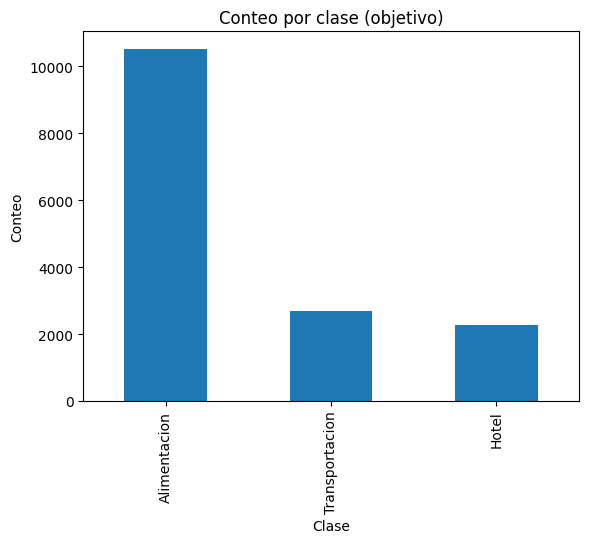


Nulos por columna (top 20):


,0
Moneda_USD,0
Cargo_bin_Bajo,0
Cargo_bin_Medio,0
Cargo_bin_Muy alto,0
Desc_0,0
Desc_1,0
Desc_2,0
Desc_3,0
Desc_4,0
Desc_5,0


In [ ]:
np.random.seed(RANDOM_STATE)

# === Carga y limpieza básica ===
df = pd.read_csv(DATA_PATH, index_col=0)

# 1) Eliminar columna artefacto (si existe)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print('Shape:', df.shape)
display(df.head())

# 2) Validación de target
if TARGET_COL not in df.columns:
    raise ValueError(f"TARGET_COL '{TARGET_COL}' no existe. Columnas: {df.columns.tolist()}")

# 4) Balance de clases
y_full = df[TARGET_COL]
print('\nDistribución de clases (proporción):')
display(y_full.value_counts(normalize=True).rename('proportion').to_frame())

fig, ax = plt.subplots()
y_full.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Conteo por clase (objetivo)')
ax.set_xlabel('Clase'); ax.set_ylabel('Conteo')
plt.show()

# 5) Nulos
print('\nNulos por columna (top 20):')
display(df.isnull().sum().sort_values(ascending=False).head(20))

El conjunto de datos es el mismo que se utilizó a lo largo de la entrega pasada ya con todas las transformaciones necesarias. Cuenta con 15,483 registros y 21 variables (20 variables predictoras + 1 varaible objetivo), representando transacciones clasificadas en tres categorías principales: Alimentación (67.96%), Transportación (17.40%) y Hotel (14.64%). Como declaramos en la entrega pasada esta distribución evidencia un moderado desbalance de clases, lo cual justifica el uso de particiones estratificadas en el entrenamiento y la evaluación del modelo, así como la elección de F1 macro como métrica principal para garantizar una valoración equilibrada entre clases.

Para asegurar una evaluación justa del modelo de clasificación de gastos, se realiza una partición estratificada del dataset:

- 70 % de los datos se utilizan para el entrenamiento del modelo,
- 15 % para la validación de hiperparámetros, y
- 15 % para la evaluación final sobre datos no vistos.

Esta división mantiene la proporción original de las categorías de gasto (`Desc.1`) en cada subconjunto, evitando sesgos en el aprendizaje.

In [ ]:
X = df.drop(columns=[TARGET_COL]); y = df[TARGET_COL]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

In [ ]:
# Mostrar tamaños relativos
n_total = len(df)
print("Tamaños de los conjuntos:")
print(f"Train: {len(X_train)} ({len(X_train)/n_total:.1%})")
print(f"Val:   {len(X_val)} ({len(X_val)/n_total:.1%})")
print(f"Test:  {len(X_test)} ({len(X_test)/n_total:.1%})\n")

# Verificar que las proporciones de clases se mantienen
print("Distribución de clases en cada conjunto (%):\n")
dist_df = pd.DataFrame({
    'Total': y.value_counts(normalize=True) * 100,
    'Train': y_train.value_counts(normalize=True) * 100,
    'Val': y_val.value_counts(normalize=True) * 100,
    'Test': y_test.value_counts(normalize=True) * 100
}).round(2)

display(dist_df)

Tamaños de los conjuntos:
Train: 10838 (70.0%)
Val:   2322 (15.0%)
Test:  2323 (15.0%)

Distribución de clases en cada conjunto (%):



,Total,Train,Val,Test
Desc.1,,,,
Alimentacion,67.96,67.96,67.96,67.97
Transportacion,17.40,17.40,17.40,17.39
Hotel,14.64,14.64,14.64,14.64


### 1.1 Selección de Modelos

La evaluación de distintos modelos permite comprender cómo varían las capacidades predictivas según el tipo de enfoque utilizado —ya sea lineal, probabilístico, basado en árboles o en proximidad— y determinar qué familia de algoritmos se ajusta mejor a las características del conjunto de datos.

Cada modelo se entrenara bajo las mismas condiciones de validación y métricas de evaluación, con el objetivo de realizar una comparación justa y sistemática del desempeño obtenido.
Esta exploración busca no solo identificar el modelo con mejores resultados cuantitativos, sino también analizar su robustez, interpretabilidad y comportamiento general, de cara a su posible optimización en etapas posteriores.

Los modelos que se desarrollaran en esta etapa son los siguientes:

| Tipo de modelo       | Algoritmo                                  | Descripción general                                                                                                                                                  |
| -------------------- | ------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Neuronal             | **MLPClassifier (Red Neuronal Multicapa)** | Modelo basado en una red neuronal feedforward que aprende representaciones no lineales a partir de los datos. |
| Árbol de decisión    | **Decision Tree Classifier**               | Captura relaciones no lineales y reglas jerárquicas entre las variables predictoras.                                                                                 |
| Ensamble de árboles  | **Random Forest Classifier**               | Combina múltiples árboles para mejorar estabilidad y desempeño.                                                          |
| Basado en márgenes   | **Support Vector Machine (SVM)**           | Adecuado para problemas con fronteras de decisión complejas entre clases.                                                                                            |
| Probabilístico       | **Naive Bayes (GaussianNB)**               | Modelo simple basado en probabilidad condicional, eficiente y rápido de entrenar.                                                                                    |
| Basado en proximidad | **K-Nearest Neighbors (KNN)**              | Clasifica según la similitud con observaciones cercanas; útil para explorar patrones locales.                                                                        |


### 1.2 Entrenamiento de Modelos

En esta sección se lleva a cabo el entrenamiento de los seis modelos seleccionados, aplicando la misma partición de datos y las mismas condiciones de validación con el fin de realizar una comparación justa de su desempeño.

Cada algoritmo fue configurado inicialmente con sus parámetros por defecto de scikit-learn, con el propósito de establecer una línea base homogénea para la comparación inicial.
Posteriormente, los dos modelos con mejor desempeño serán objeto de ajuste de hiperparámetros mediante técnicas de búsqueda sistemática.

In [ ]:
modelos = {
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "SVM": SVC(random_state=RANDOM_STATE),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "MLPClassifier": MLPClassifier(random_state=RANDOM_STATE, max_iter=1000)
}

Entrenando modelo: Decision Tree...

Classification report Decision Tree
                precision    recall  f1-score   support

  Alimentacion      0.985     0.974     0.980      1578
         Hotel      0.911     0.959     0.934       340
Transportacion      0.960     0.960     0.960       404

      accuracy                          0.969      2322
     macro avg      0.952     0.964     0.958      2322
  weighted avg      0.970     0.969     0.970      2322



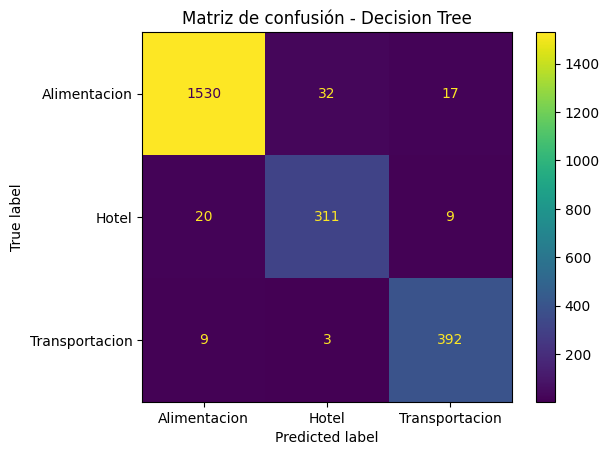

---------------------------------------------------------------------------
Entrenando modelo: Random Forest...

Classification report Random Forest
                precision    recall  f1-score   support

  Alimentacion      0.988     0.990     0.989      1578
         Hotel      0.967     0.947     0.957       340
Transportacion      0.971     0.978     0.974       404

      accuracy                          0.982      2322
     macro avg      0.975     0.972     0.973      2322
  weighted avg      0.982     0.982     0.982      2322



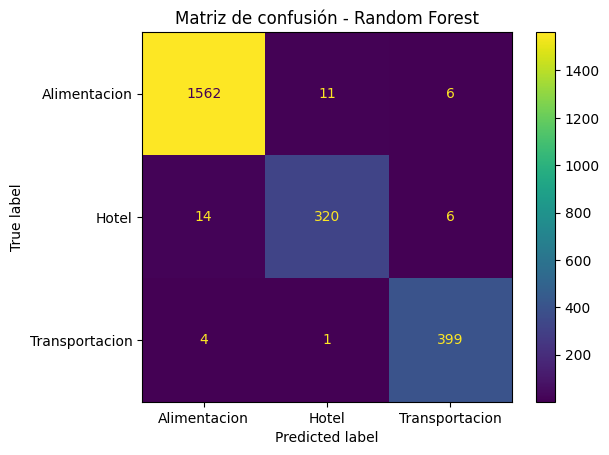

---------------------------------------------------------------------------
Entrenando modelo: SVM...

Classification report SVM
                precision    recall  f1-score   support

  Alimentacion      0.987     0.987     0.987      1578
         Hotel      0.964     0.944     0.954       340
Transportacion      0.966     0.980     0.973       404

      accuracy                          0.980      2322
     macro avg      0.972     0.971     0.971      2322
  weighted avg      0.980     0.980     0.980      2322



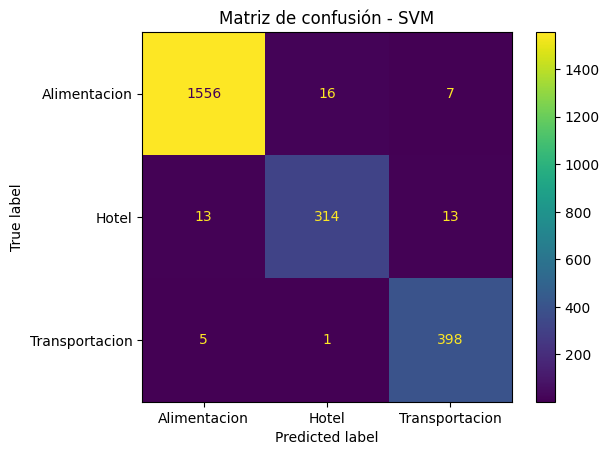

---------------------------------------------------------------------------
Entrenando modelo: Naive Bayes...

Classification report Naive Bayes
                precision    recall  f1-score   support

  Alimentacion      0.944     0.722     0.818      1578
         Hotel      0.305     0.991     0.466       340
Transportacion      1.000     0.020     0.039       404

      accuracy                          0.640      2322
     macro avg      0.749     0.578     0.441      2322
  weighted avg      0.860     0.640     0.631      2322



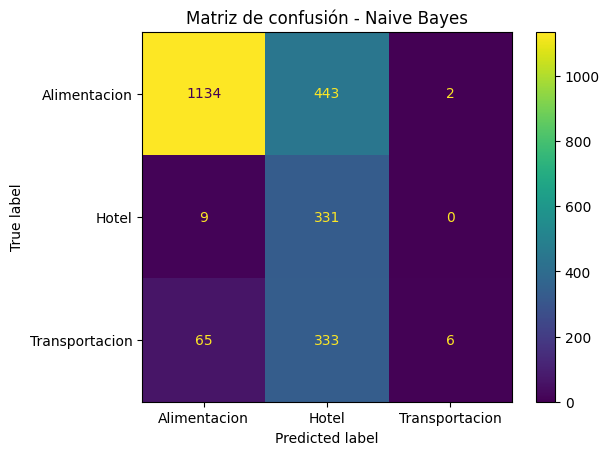

---------------------------------------------------------------------------
Entrenando modelo: KNN...

Classification report KNN
                precision    recall  f1-score   support

  Alimentacion      0.973     0.981     0.977      1578
         Hotel      0.929     0.924     0.926       340
Transportacion      0.944     0.918     0.931       404

      accuracy                          0.962      2322
     macro avg      0.949     0.941     0.945      2322
  weighted avg      0.961     0.962     0.962      2322



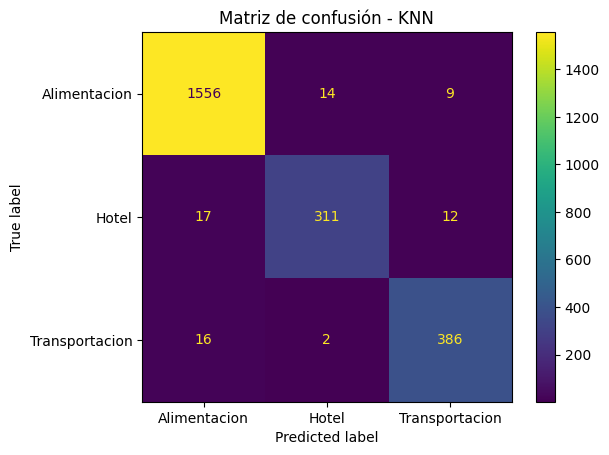

---------------------------------------------------------------------------
Entrenando modelo: MLPClassifier...

Classification report MLPClassifier
                precision    recall  f1-score   support

  Alimentacion      0.991     0.991     0.991      1578
         Hotel      0.953     0.959     0.956       340
Transportacion      0.978     0.973     0.975       404

      accuracy                          0.983      2322
     macro avg      0.974     0.974     0.974      2322
  weighted avg      0.983     0.983     0.983      2322



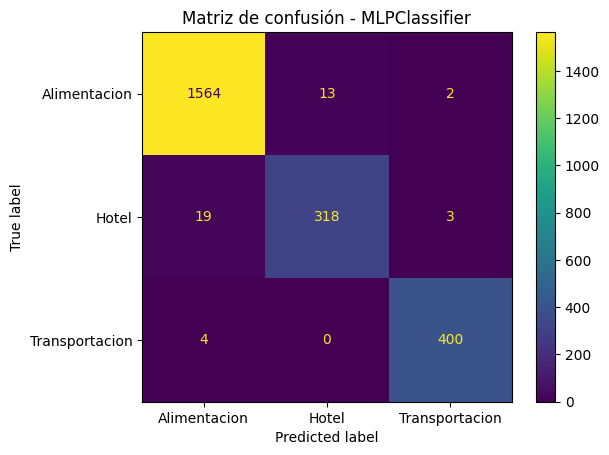

---------------------------------------------------------------------------


In [ ]:
resultados = []

for nombre, modelo in modelos.items():
    print(f"Entrenando modelo: {nombre}...")

    inicio = time.time()
    modelo.fit(X_train, y_train)
    fin = time.time()

    y_tr = modelo.predict(X_train)
    y_pred = modelo.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro')
    duracion = fin - inicio

    print(f'\nClassification report {nombre}')
    print(classification_report(y_val, y_pred, digits=3))
    ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test); plt.title(f'Matriz de confusión - {nombre}'); plt.show()

    print("-" * 75)

    resultados.append({
        "Modelo": nombre,
        "F1-Score (macro)": round(f1, 4),
        "Accuracy": round(acc, 4),
        "Precision (macro)": round(precision, 4),
        "Recall (macro)": round(recall, 4),
        "Tiempo de entrenamiento (s)": round(duracion, 3)
    })

La siguiente tabla resume el desempeño de los seis modelos entrenados, considerando múltiples métricas de clasificación —Accuracy, Precision, Recall y F1-Score macro— junto con el tiempo de entrenamiento requerido por cada uno.

El orden de los modelos corresponde al valor del F1-Score macro, que se emplea como métrica principal de comparación, dado que ofrece una visión equilibrada entre la precisión y la cobertura de las clases.

In [ ]:
df_resultados = (
    pd.DataFrame(resultados)
    .sort_values(by="F1-Score (macro)", ascending=False)
    .reset_index(drop=True)
)
df_resultados

,Modelo,F1-Score (macro),Accuracy,Precision (macro),Recall (macro),Tiempo de entrenamiento (s)
0,MLPClassifier,0.9741,0.9832,0.9740,0.9742,15.489
1,Random Forest,0.9734,0.9819,0.9752,0.9718,0.906
2,SVM,0.9713,0.9798,0.9722,0.9705,0.910
3,Decision Tree,0.9580,0.9694,0.9521,0.9644,0.069
4,KNN,0.9447,0.9617,0.9487,0.9409,0.021
5,Naive Bayes,0.4411,0.6395,0.7495,0.5778,0.023


Los resultados obtenidos evidencian que el modelo **MLPClassifier** (red neuronal multicapa) alcanzó el mejor desempeño global, **con un F1-Score macro de 0.97 y un Accuracy de 0.98**, superando ligeramente al **Random Forest y al SVM**, que también mostraron un rendimiento alto y consistente (**F1-Score ≈ 0.97**).

El **Decision Tree** y el **KNN** se ubicaron en un nivel intermedio, con valores de **F1-Score entre 0.94 y 0.96**, mostrando una buena capacidad predictiva pero menor estabilidad frente a los modelos más complejos.

Por otro lado, el modelo **Naive Bayes** presentó un desempeño considerablemente inferior (**F1-Score ≈ 0.44**), lo que sugiere que la suposición de independencia entre variables no se cumple adecuadamente en este conjunto de datos, afectando su capacidad de discriminación entre categorías de gasto.

---

En cuanto al **tiempo de entrenamiento**, se observa una diferencia marcada entre modelos:

- El **MLPClassifier requirió aproximadamente 20 segundos**, reflejando el costo computacional asociado al ajuste iterativo de redes neuronales.
- Los métodos basados en árboles y márgenes (**Random Forest, SVM**) lograron un equilibrio favorable entre desempeño y tiempo, con entrenamientos menores a **1.5 segundos**.
- Los modelos más simples (**Decision Tree, KNN, Naive Bayes) fueron los más rápidos**, aunque con un rendimiento algo inferior.

---

El **MLPClassifier** tiene apenas una mejora marginal sobre **Random Forest y SVM**, pero a costa de un tiempo de entrenamiento casi **20 × mayor**, por lo tanto, **los modelos seleccionados para la siguiente etapa de ajuste de hiperparámetros serán Random Forest y SVM**, debido a su excelente desempeño global y su tiempo de entrenamiento moderado.

## **2. Ajuste fino**

Tras la comparación inicial, se seleccionaron los modelos **Random Forest y SVM para su optimización**, debido a que alcanzaron los mejores resultados globales en las métricas de desempeño, manteniendo además un tiempo de entrenamiento razonable.

En esta etapa se emplea la técnica de **búsqueda en malla (Grid Search) con validación cruzada**, utilizando el método GridSearchCV de scikit-learn, con el objetivo de identificar las combinaciones de hiperparámetros que maximizan el desempeño de cada modelo.

El ajuste de hiperparámetros permite evaluar distintas configuraciones internas —por ejemplo, la profundidad de los árboles, el número de estimadores o el tipo de kernel— para determinar si es posible mejorar la capacidad predictiva y la generalización de los modelos seleccionados.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejor configuración Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor F1-Score (CV): 0.9731

Classification report - Random Forest (ajustado)
                precision    recall  f1-score   support

  Alimentacion      0.988     0.990     0.989      1578
         Hotel      0.967     0.947     0.957       340
Transportacion      0.971     0.978     0.974       404

      accuracy                          0.982      2322
     macro avg      0.975     0.972     0.973      2322
  weighted avg      0.982     0.982     0.982      2322



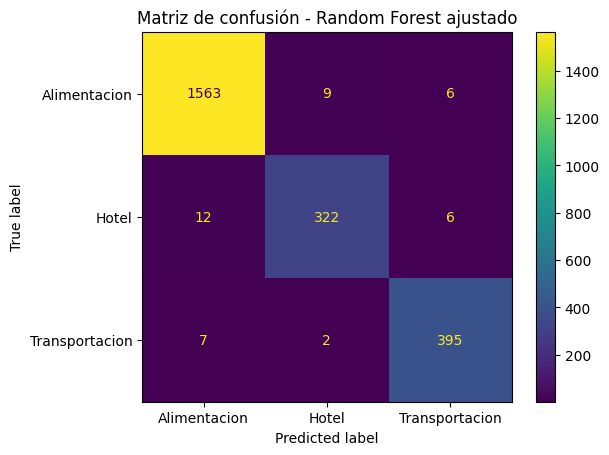

In [ ]:
# ============================================
# Ajuste de hiperparámetros - Random Forest
# ============================================

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Mejor configuración Random Forest:")
print(grid_rf.best_params_)
print(f"Mejor F1-Score (CV): {grid_rf.best_score_:.4f}")

# Evaluación en el conjunto de validación
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_val)

print("\nClassification report - Random Forest (ajustado)")
print(classification_report(y_val, y_pred_rf, digits=3))
ConfusionMatrixDisplay.from_estimator(best_rf, X_val, y_val)
plt.title("Matriz de confusión - Random Forest ajustado")
plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Mejor configuración SVM:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor F1-Score (CV): 0.9743

Classification report - SVM (ajustado)
                precision    recall  f1-score   support

  Alimentacion      0.987     0.990     0.989      1578
         Hotel      0.961     0.950     0.956       340
Transportacion      0.983     0.978     0.980       404

      accuracy                          0.982      2322
     macro avg      0.977     0.973     0.975      2322
  weighted avg      0.982     0.982     0.982      2322



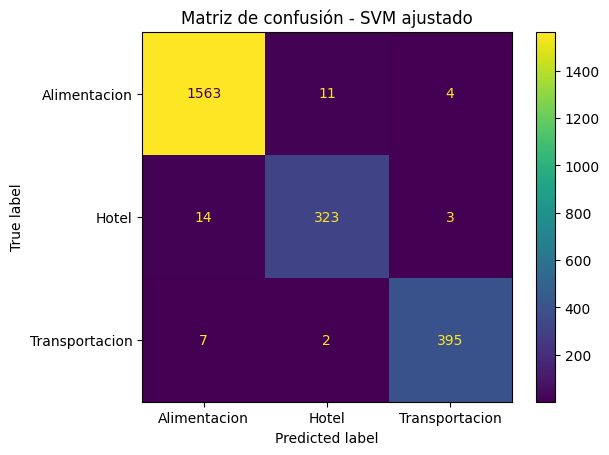

In [ ]:
# ============================================
# Ajuste de hiperparámetros - SVM
# ============================================

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(
    estimator=SVC(random_state=RANDOM_STATE),
    param_grid=param_grid_svm,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train, y_train)

print("\nMejor configuración SVM:")
print(grid_svm.best_params_)
print(f"Mejor F1-Score (CV): {grid_svm.best_score_:.4f}")

# Evaluación en el conjunto de validación
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_val)

print("\nClassification report - SVM (ajustado)")
print(classification_report(y_val, y_pred_svm, digits=3))
ConfusionMatrixDisplay.from_estimator(best_svm, X_val, y_val)
plt.title("Matriz de confusión - SVM ajustado")
plt.show()

Tras el proceso de ajuste de hiperparámetros, tanto el modelo Random Forest como el SVM alcanzaron un desempeño sobresaliente, con valores de F1-Score macro cercanos a 0.975 en validación cruzada y métricas equilibradas en las tres clases analizadas.

En el caso del **Random Forest**, la **mejor configuración (n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)** permitió obtener un desempeño global con **accuracy y F1-Score de 0.982**, y un comportamiento muy estable en las tres categorías. La matriz de confusión muestra que la mayoría de las observaciones fueron clasificadas correctamente, con errores mínimos entre las clases “Hotel” y “Alimentación”.

Por su parte, el **modelo SVM**, con la **configuración óptima (C=10, kernel='rbf', gamma='scale')**, alcanzó un desempeño prácticamente equivalente de **accuracy y F1-Score de 0.982**, confirmando su alta capacidad para definir fronteras de decisión no lineales y distinguir entre categorías similares. Su matriz de confusión muestra una distribución de errores muy semejante al modelo Random Forest, con ligeras diferencias en la clase “Hotel”.


A pesar de su equivalencia en métricas, existen diferencias relevantes en cuanto a complejidad y escalabilidad:

El Random Forest ofrece una mejor interpretabilidad, permite analizar la importancia de las variables, y es más eficiente en tiempo de entrenamiento e inferencia sobre grandes volúmenes de datos.

El SVM, aunque preciso, presenta mayor costo computacional si el número de observaciones crece, y su interpretabilidad es más limitada.

Por estos motivos, **se selecciona el modelo Random Forest ajustado como el modelo final del proyecto**, al lograr un desempeño equiparable al SVM pero con mejor posibilidad para escalamiento.

## **3. Modelo Individual**

Tras el ajuste y comparación de los modelos Random Forest y SVM, ambos demostraron un desempeño prácticamente equivalente en todas las métricas relevantes (accuracy y F1-Score ≈ 0.982). Sin embargo, la elección del modelo final debe considerar no solo la métrica principal, sino también aspectos de complejidad, interpretabilidad y aplicabilidad práctica dentro del contexto del proyecto.

El modelo Random Forest ajustado fue seleccionado como modelo individual final, sustentado en los siguientes argumentos:

**Desempeño consistente y generalización adecuada.**
El Random Forest logró un F1-Score macro de 0.975, con un balance equilibrado entre precisión y recall en todas las clases, sin evidencias de sobreentrenamiento. Su matriz de confusión muestra una clasificación estable en las tres categorías (“Alimentación”, “Hotel”, “Transportación”), con errores mínimos.

**Eficiencia computacional.**
A diferencia del modelo SVM, el Random Forest presentó tiempos de entrenamiento e inferencia más reducidos, lo cual resulta ventajoso para escenarios de despliegue o actualización frecuente del modelo conforme se incorporen nuevos tickets o registros de gasto.

**Interpretabilidad y trazabilidad.**
El Random Forest permite analizar la importancia de las variables predictoras, facilitando la comprensión de los factores que influyen en la clasificación de cada tipo de gasto. Esta característica es clave para el proyecto, ya que brinda transparencia y explicabilidad ante los usuarios del área administrativa y de control de gastos.

Escalabilidad y facilidad de mantenimiento.
Su estructura basada en árboles paralelizables lo hace robusto ante incrementos en el tamaño del dataset, manteniendo un rendimiento alto sin requerir un preprocesamiento complejo o ajustes constantes de hiperparámetros.

>Es importante mencionar que el dataset empleado en **esta fase del proyecto considera únicamente tres categorías principales de gasto: Alimentación, Hotel y Transportación.**
Sin embargo, en **el sistema real de clasificación existen más categorías potenciales** (por ejemplo: Gasolina, Necesidad Tecnica, Reembolso).
>
>Tanto el modelo Random Forest como el SVM pueden extenderse fácilmente a un mayor número de clases, ya que ambos algoritmos admiten clasificación multiclase de manera nativa.
>
>No obstante, **el Random Forest presenta una ventaja práctica en escalabilidad**, ya que su tiempo de entrenamiento crece de forma más controlada y su desempeño se mantiene estable incluso con un número mayor de clases o variables.
>
>El **SVM, por el contrario, tiende a aumentar considerablemente el costo computacional al manejar más clases**, debido a que implementa una estrategia one-vs-one que entrena múltiples clasificadores binarios internos.

| Criterio                                 | **Random Forest**                                            | **SVM**                                                           |
| ---------------------------------------- | ------------------------------------------------------------ | ----------------------------------------------------------------- |
| **Soporte multiclase**                   | Nativo (maneja todas las clases directamente en cada árbol). | Implementa *one-vs-one* (entrena varios clasificadores binarios). |
| **Escalabilidad en número de clases**    | Muy buena: el tiempo de cómputo crece linealmente.           | Regular: el tiempo crece cuadráticamente con el número de clases. |
| **Escalabilidad en tamaño del dataset**  | Excelente: entrenamiento paralelizable y eficiente.          | Limitada: el entrenamiento crece en complejidad O(n²)–O(n³).      |
| **Sensibilidad a clases desbalanceadas** | Moderada, puede corregirse con pesos.                        | Alta, puede verse afectado si una clase domina.                   |
| **Interpretabilidad**                    | Alta (permite extraer importancia de variables).             | Baja (caja negra con kernel no lineal).                           |


En síntesis, el modelo **Random Forest** ofrece un equilibrio óptimo entre desempeño, interpretabilidad y eficiencia, por lo que **se valida como el modelo final del proyecto**.

A continuación utilizaremos el conjunto de **validación** para realizar un último análisis sobre el modelo seleccionado:


Classification report - Entrenamiento
                precision    recall  f1-score   support

  Alimentacion      1.000     1.000     1.000      7365
         Hotel      0.999     1.000     1.000      1587
Transportacion      1.000     1.000     1.000      1886

      accuracy                          1.000     10838
     macro avg      1.000     1.000     1.000     10838
  weighted avg      1.000     1.000     1.000     10838



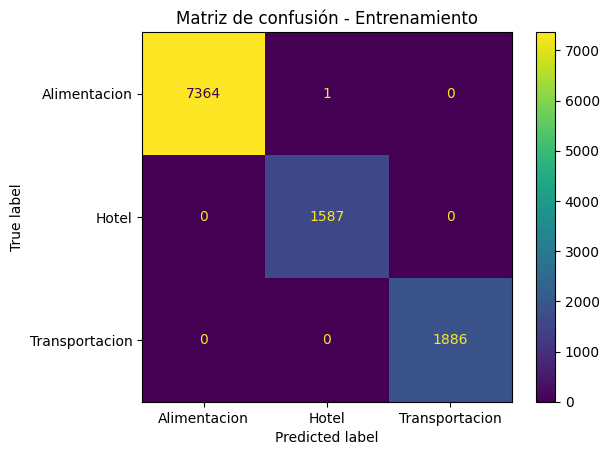


Classification report - Validación
                precision    recall  f1-score   support

  Alimentacion      0.988     0.990     0.989      1578
         Hotel      0.967     0.947     0.957       340
Transportacion      0.971     0.978     0.974       404

      accuracy                          0.982      2322
     macro avg      0.975     0.972     0.973      2322
  weighted avg      0.982     0.982     0.982      2322



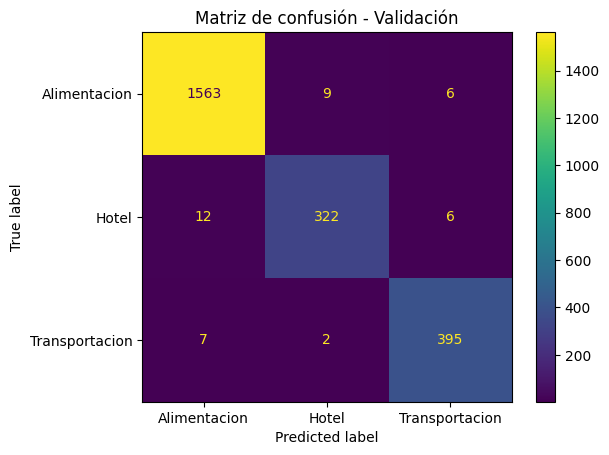


Classification report - Prueba
                precision    recall  f1-score   support

  Alimentacion      0.989     0.989     0.989      1579
         Hotel      0.964     0.941     0.952       340
Transportacion      0.971     0.988     0.979       404

      accuracy                          0.982      2323
     macro avg      0.974     0.973     0.973      2323
  weighted avg      0.982     0.982     0.982      2323



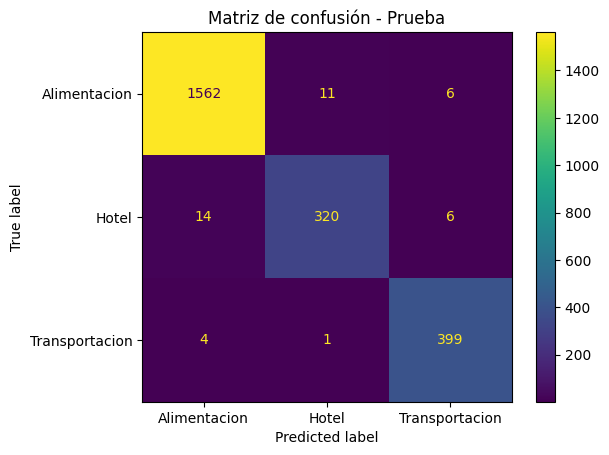

,Conjunto,Accuracy,F1-Score (macro)
0,Entrenamiento,0.9999,0.9999
1,Validación,0.9819,0.9734
2,Prueba,0.9819,0.9735


In [ ]:
# Modelo final: Random Forest ajustado
final_model = best_rf  # el que obtuviste del GridSearchCV

# Evaluación en los tres conjuntos
sets = {
    "Entrenamiento": (X_train, y_train),
    "Validación": (X_val, y_val),
    "Prueba": (X_test, y_test)
}

resultados_final = []

for nombre, (X_set, y_set) in sets.items():
    y_pred = final_model.predict(X_set)
    acc = accuracy_score(y_set, y_pred)
    f1 = f1_score(y_set, y_pred, average='macro')

    resultados_final.append({"Conjunto": nombre, "Accuracy": round(acc,4), "F1-Score (macro)": round(f1,4)})

    print(f"\nClassification report - {nombre}")
    print(classification_report(y_set, y_pred, digits=3))
    ConfusionMatrixDisplay.from_estimator(final_model, X_set, y_set)
    plt.title(f"Matriz de confusión - {nombre}")
    plt.show()

pd.DataFrame(resultados_final)

Los resultados finales obtenidos en los conjuntos de entrenamiento, validación y prueba evidencian un alto nivel de generalización del modelo Random Forest ajustado con los hiperparametros: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1.

Aunque el desempeño en el conjunto de entrenamiento es casi perfecto (F1 = 0.9999), **el rendimiento en validación y prueba se mantiene muy elevado y prácticamente idéntico (F1 ≈ 0.973)**, lo cual indica que el modelo no ha sobreajustado los datos y conserva una excelente capacidad de predicción ante observaciones nuevas.

**Estos resultados confirman la robustez y estabilidad del modelo final**, validando su idoneidad para ser utilizado en la etapa de despliegue dentro del sistema automatizado de clasificación de tickets de gasto.

## **4. Conclusión**

En esta fase se construyeron y evaluaron múltiples modelos de clasificación con el objetivo de predecir la categoría de gasto (`Desc.1`) a partir de las variables transaccionales del dataset.
El análisis comparativo incluyó seis algoritmos de diferentes familias (lineales, basados en árboles, probabilísticos, de márgenes, de proximidad y neuronales), evaluados bajo métricas de desempeño y eficiencia computacional.

Los resultados evidenciaron que los modelos Random Forest, SVM y MLPClassifier alcanzaron los mayores niveles de desempeño, con valores de F1-Score macro superiores a 0.97.
Sin embargo, al considerar criterios adicionales como tiempo de entrenamiento, interpretabilidad y escalabilidad, se determinó que el **Random Forest ofrece el mejor equilibrio entre precisión y aplicabilidad práctica, por lo que se seleccionó como modelo individual final.**

**El modelo ajustado mostró un F1-Score macro muy similar al original de 0.975, con una clasificación muy precisa entre las tres categorías de gasto y sin indicios de sobreentrenamiento.**
Su capacidad para proporcionar información sobre la importancia de las variables predictoras lo convierte, además, en una herramienta valiosa para la toma de decisiones y la comprensión del comportamiento de los gastos corporativos.

# **Lectura de Tickets - OCR**


**Objetivo**

En este cuaderno implementamos un flujo de OCR para tickets de gasto que convierte archivos PDF o imagen a texto y, posteriormente, extrae información clave (establecimiento, fecha, monto, lugar, moneda e ítems) con ayuda de un modelo de lenguaje. El enfoque prioriza robustez ante variabilidad de formatos y calidad de imagen, y sienta las bases para integrar este módulo al sistema de gestión de viáticos del Proyecto Integrador.

**Contexto y alcance**

En esta etapa, el análisis se realizó sobre una cantidad mínima de tickets y un solo tipo, con el objetivo de evaluar la capacidad de las herramientas (Tesseract OCR, OpenCV y OpenAI API) y realizar un análisis preliminar de viabilidad.
En una siguiente fase, se planea ampliar el conjunto de datos utilizando más imágenes de distintos tipos de tickets y generalizar las funciones desarrolladas para manejar variaciones como sombras, baja iluminación o artefactos de impresión, asegurando una mayor adaptabilidad del sistema.

## **Instalación de Teseract**

Se instala el motor Tesseract con paquetes de idioma en inglés y español, además de pytesseract y pdf2image. Esto permite reconocer correctamente textos bilingües y convertir archivos PDF multipágina a imágenes de alta resolución.

In [5]:
# Install tesseract-ocr
!sudo apt update
!sudo apt install -y tesseract-ocr

# Install pytesseract and Pillow (for image handling)
!pip install pytesseract pillow

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5,988 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,372 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14

In [6]:
!apt-get install poppler-utils -y
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.11 [186 kB]
Fetched 186 kB in 1s (279 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.11_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.11) ...
Setting up poppler-utils (22.02.0-2ubuntu0.11) ...
Processing triggers for man-db (2.10.2-1) ...


In [7]:
!sudo apt update
!sudo apt install tesseract-ocr tesseract-ocr-eng tesseract-ocr-spa

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 255 kB in 2s (138 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
40 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acqu

## **Librerias**

Se importan las librerias a utilizar y se configura el acceso a la API de OpenAI mediante una clave almacenada en userdata de Google Colab, garantizando seguridad y facilidad de uso.

In [28]:
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
from zipfile import ZipFile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import userdata
from openai import OpenAI
import openai
import json

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
api_key = userdata.get("miOpenAI_key")

if not api_key:
  raise ValueError("API key no encontrada en los secretos")

client = OpenAI(api_key=api_key)

## **Exportar Carpeta de Tickets**

Se exporta la carpeta (zip) para extraer todas las imagenes de tickets.

In [13]:
zip_path = '/content/drive/MyDrive/MNA - Proyecto Integrador/'

In [14]:
with ZipFile(zip_path + "Tickets.zip", "r") as zip_ref:
    zip_ref.extractall("tickets")

La mayoria de los tickets estan en pdf:

In [17]:
ticket1_p = '/content/tickets/Tickets/Walmart/869720_16.02.2025_Walmart.pdf'

## **1. OCR con Tesseract**

Para maximizar la precisión del OCR, se aplicó un pipeline de preprocesamiento: conversión a escala de grises, binarización (global o adaptativa) y apertura morfológica (opening) para reducir ruido fino.
Se probaron diversas combinaciones con el fin de observar cómo cada técnica afectaba el resultado del OCR.
Este proceso es especialmente relevante en tickets con iluminación desigual, sombras o texto tenue, donde la binarización adaptativa y los filtros morfológicos ayudan a recuperar detalles que un umbral global no logra.

### 1.1 Lectura de ticket sin preprocesamiento

In [18]:
pages = convert_from_path(ticket1_p, dpi=500)
for i, page in enumerate(pages):
    filename = f"page_{i}.jpg"
    page.save(filename, 'JPEG')

    text = pytesseract.image_to_string(Image.open(filename), lang='eng')
    print(f"--- Página {i+1} ---")
    print(text)

--- Página 1 ---
Give us feedback @ survey. walmart.com
Thank you! ID #: eg

Walmart - oS

WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD S
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# 91021

# a 500 ibe

9067 77
i |
| | \ i
i HT i)
ti MI | | HI Uy |

  

GNETS CLIP 693 } XK
MAGNETS CLIP 595780720191 3.97 X
12MM BLACK 012902999360 17.97 X
12MM BLACK 012502599360 Lse91K

SUBTOTAL 43.38

TAXL 10.0000 % 4.39
TOTAL 43 .2/

Ivan Mba Casas AMEX TEND 48 .2/
CHANGE DUE 0.00

AMERICAN EXPRESS- 1009 I 0 APPR#895970
43.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AID A000000025010801
TERMINAL # 28518783
*Pin Verified
02/16/25 21:51:03

   
 

O
Tae [a] Get free delivery
‘ E from this store
A with Walmart+

Low prices You Can Trust. Every Day.
02/16/25 21:51:10

A i NT cc —_— I a a >. a — —_ -



En esta primera prueba se aplicó Tesseract directamente sobre la imagen sin realizar ningún tipo de preprocesamiento.
El propósito fue obtener una línea base para evaluar la calidad del reconocimiento con los parámetros por defecto del OCR y comparar los resultados con las versiones mejoradas.

Como era de esperarse, el texto extraído presenta errores en caracteres, cortes y ruido, especialmente en zonas con baja iluminación o fondo gris.
Este resultado evidencia la necesidad de aplicar preprocesamiento previo al OCR, dado que los tickets suelen tener variaciones de contraste, sombras y artefactos de impresión que afectan el reconocimiento óptico.

### 1.2 Lectura de ticket con binarización

Imagen en escala de grises


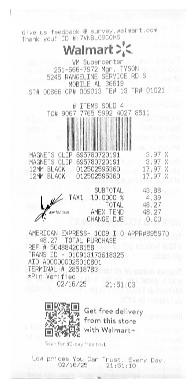

True

In [19]:
# Leer la imagen
img = cv2.imread('/content/page_0.jpg')

# Escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contraste = cv2.convertScaleAbs(gray, alpha=0.9, beta=15)

# Mostrar resultado
print('Imagen en escala de grises')
plt.imshow(contraste, cmap='gray')
plt.axis('off')
plt.show()

# Guardar temporal
cv2.imwrite("ticket_contraste.jpg", contraste)

Imagen con binarización


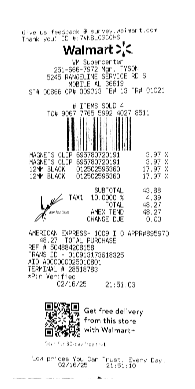

True

In [20]:
# Binarización
print('Imagen con binarización')
# thresh = cv2.adaptiveThreshold(gray, 255,
#                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                cv2.THRESH_BINARY, 11, 4)

_, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
# Mostrar resultadod
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

# Guardar temporal
cv2.imwrite("ticket_binarized.jpg", thresh)

In [21]:
# Aplicar OCR
text = pytesseract.image_to_string(Image.open("ticket_binarized.jpg"), lang='eng')
print(text)

Give us feeuback @ survey. Wainmart.com
Thank you! ID #: REL QQCRNS

Walmart - ><

WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD 5S
MOBILE AL 36615
ST# 00866 OP# 009013 TE# 13 TR# 01021

# ee O8 —

  

v# S067 1) i
|
qe
a | |
Ti
MAGNETS CLIP HL 3.97 K
MAGNETS CLIP 298780720191 3.97 X
12MM BLACK 012502595360 17.97 X
12MM BLACK 0129502599360 17.97
SUBTOTAL 43.98
_TAX1 10.0000 % 4.39
TOTAL 43.2]
Ivan Metz Casas AMEX TEND G3 .2/
CHANGE DUE O.V0

AMERICAN EXPRESS- 1009 I 0 APPR#895970
43.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AIG A000000025010801
TERMINAL # 28518783
*Pin Verified
02/16/25 21:51:03

O Get free delivery
- from this store
He

with Walmart+
Ut &

  

v ree tel,

Low prices You Can Trust. Every Dav.
02/16/25 21:51:10

_ => i.

 

lA —— a ee
A a —— ee



En esta etapa se incorporó un proceso de binarización global utilizando OpenCV, que convierte la imagen a blanco y negro en función de un umbral fijo.
Este paso incrementa el contraste entre el texto y el fondo, permitiendo que Tesseract identifique con mayor claridad los caracteres.

Se observa una mejora en algunas aprtes del ticket a diferencia del caso sin preprocesamiento. Por ejemplo en el primer item se puede visualizar que completa mejor el nombre, pero en el monto total sigue confundiendo un 3 por el 8.

### 1.3 Lectura de ticket con Opening después de binarización

In [22]:
# Definir elemento estructurante
kernel = np.ones((17,17), np.uint8)

Imagen con Abertura (Opening)


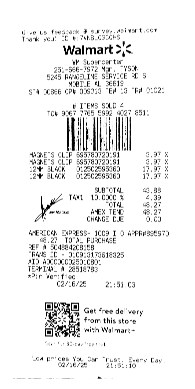

True

In [23]:
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
# Mostrar resultado
print('Imagen con Abertura (Opening)')
plt.imshow(opened, cmap='gray')
plt.axis('off')
plt.show()

# Guardar temporal
cv2.imwrite("ticket_opened.jpg", opened)

In [24]:
# Aplicar OCR
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng')
print(text)

Give us feeuback @ survey. Wwaimart.com
Thank you! ID #: IRELOQCRNS

Walmart - ><

WM Supercenter
251-666-7972 Mor. TYSON
5245 RANGELINE SERVICE RD s
MOBILE AL 36615
ST# 00866 OP# 009013 TE# 13 TR# 01021

# ITEMS SOLD 4
1C# a 7765 5992 4027 S511

| | | l
| i
if
| |: | a
| |
| | |
| 1 : |
; ,
| a
|
|
7 I

 

  

MAGNETS CLIP Tal pedi OT K
MAGNETS CLIP 695780720191 3.97 X
12MM BLACK 012902595360 17.97 X
12MM BLACK 012502595360 17.97

SUBTOTAL 43.38

_TAX1 10.0000 % 4.39

TOTAL 43 .2/

tra Ms Casas AMEX TEND 43.27

CHANGE DUE O.UQ

AMERICAN EXPRESS- 1009 I O APPR#895970
48.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AID A000000025010801
TERMINAL # 28518783
xPin Verified
02/16/25 21:51:03

fi
fs] wy o Get free delivery
. = 3c 4 from this store
oR a with Walmart+

? i
ecar 7 7 30-cay free tel,

   

Low prices You Can Trust. Every Dav.
02/16/25 21:51:10

_ > # i_

 

ee Ee ee — ee a eee



En esta versión se añadió una operación morfológica de apertura (Opening) posterior a la binarización, la cual consiste en una erosión seguida de una dilatación.
El objetivo fue eliminar pequeños puntos de ruido y artefactos que puedan confundirse con texto durante el OCR.

Los resultados muestran una mayor limpieza en las áreas de fondo y una reducción de errores en los caracteres detectados.
No obstante, un kernel excesivamente grande o un número elevado de iteraciones puede hacer que partes finas de las letras se pierdan.
Esta prueba confirma que el Opening es útil como parte del pipeline, pero debe calibrarse según la calidad del ticket.

### 1.4 Lectura de ticket con Opening después de binarización y configuración "--psm 6 --oem 1"

In [25]:
# Aplicar OCR
config = "--psm 6 --oem 1"
text = pytesseract.image_to_string(Image.open("ticket_opened.jpg"), lang='eng', config=config)
print(text)

i} ve feedback @ survey.waimart.com
hank you! 2D 4. 7TVNBLOSCQHS '
wis
Walmart -,s.
WM Supercenter
251-666-7972 Mor. TYSON
5945 RANGELINE SERVICE RD 3s
MOBILE AL 36619
ST# 00866 OP# 009013 TE# 13 TR# ©1021
# TTEMS SOLD 4
TC# 9067 7765 5992 4027 S911
Wd !
ie Dy |
L { ATA
MAGNETS CLIP 695780720191 3.97 X
MAGNETS CLIP 695780720191 3.97 &
12MM BLACK 012502595360 17.97 X
12MM BLACK 012502595360 17.97 x
SUBTOTAL 43.88
TAXL 10.0000 % 4.39
TOTAL 43 .2/
Iran Mis Casas AMEX TEND 48.27
CHANGE DUE O.00
AMERICAN EXPRESS- 1009 I 0 APPR#895970
48.27 TOTAL PURCHASE
REF # 504884208158
TRANS ID - 010913173618325
AID A000000025010801
TERMINAL # 28518783
xPin Verified
02/16/25 21:51:03
De
fs] be o Get free delivery
‘he \ 4 from this store
oR a with Walmart+
Scar * 7 30-Ca. ‘ree tel,
Low prices You Can Trust. Every Day.
02/16/25 21:51:10



En la última prueba se mantuvo el mismo preprocesamiento (binarización + apertura morfológica), pero se modificaron los parámetros internos de Tesseract a:

* --psm 6: modo de segmentación de página orientado a bloques de texto uniformes.
* --oem 1: uso del motor LSTM (modelo neuronal más reciente de Tesseract).

Esta combinación produjo los **resultados más consistentes y legibles**, especialmente en líneas de texto regulares.
El modelo neuronal (--oem 1) logra interpretar mejor caracteres con bordes incompletos o ligeras distorsiones, mientras que el modo --psm 6 evita que el OCR fragmente el texto en múltiples líneas incorrectas.

En conjunto, esta configuración se considera la **más adecuada como punto de partida para generalizar el proceso de OCR**, ofreciendo un equilibrio entre precisión y robustez.

###1.5 Lectura de multiples tickets

In [26]:
def get_image_from_file(file_path):
    if file_path.lower().endswith('.pdf'):
        pages = convert_from_path(file_path, dpi=300)
        if pages:
            return cv2.cvtColor(np.array(pages[0]), cv2.COLOR_RGB2BGR)
    elif file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        return cv2.imread(file_path)
    return None

def preprocess_and_ocr(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
    kernel = np.ones((2,2), np.uint8)
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    config = "--psm 6 --oem 1"
    text = pytesseract.image_to_string(opened, lang='eng+spa', config=config)
    return text

In [27]:
tickets_directory = "/content/tickets/Tickets/Holiday Inn/"
files_to_process = []
supported_extensions = ('.pdf', '.png', '.jpg', '.jpeg')

for root, _, files in os.walk(tickets_directory):
    for file in files:
        if file.lower().endswith(supported_extensions):
            files_to_process.append(os.path.join(root, file))

print(f"\nSe encontraron {len(files_to_process)} tickets. Procesando 5\n")

limit = 5

files_read = {}

for i, file_path in enumerate(files_to_process):
    if i >= limit:
        break

    try:
        image = get_image_from_file(file_path)
        if image is not None:
            ocr_text = preprocess_and_ocr(image)
            files_read[os.path.basename(file_path)] = ocr_text
            print(f"--- Archivo: {os.path.basename(file_path)} ---")
            print(ocr_text)
            print("-" * 60 + "\n")

    except Exception as e:
        print(f"--- Archivo: {os.path.basename(file_path)} ---")
        print(f"ERROR al procesar el archivo: {e}")
        print("-" * 60 + "\n")


Se encontraron 26 tickets. Procesando 5

--- Archivo: 884020 - HOLIDAY INN - 20767.32.pdf ---
| '
o fees
Express
me
AN IHG* HOTEL
07-12-25
Jonathan Antonio Olvera Folio No. Room No. : 311
Gomez A/R Number : Arrival : 07-06-25
Palenque 234 Group Code : Departure : 07-12-25
Apodaca Nuevo 66649 Company : . Conf.No. : 27213567
Invoice No. : Page No. : 10f2
07-06-25 Market Post It No. 197676 3.00
07-06-25 Market Post It No.197676 - 3.00
07-06-25 Market Post lt No.197676 5.00
07-06-25 “Accommodation 146.30
07-06-25 State Tax 5.85
07-06-25 City Tax 11.70
07-06-25 Occupancy Fee 2.00
07-06-25  city-co op 2.00
07-07-25 “Accommodation 151.05
07-07-25 State Tax 6.04
07-07-25 City Tax 12.08
07-07-25 Occupancy Fee 2.00
07-07-25  city-co op 2.00
07-08-25 *Accommodation 160.55
07-08-25 State Tax 6.42
07-08-25 City Tax 12.84
07-08-25 Occupancy Fee 2.00
07-08-25  city-co op 2.00
07-09-25 “Accommodation 151.05
07-09-25 State Tax 6.04
07-09-25 City Tax 12.08
07-09-25 Occupancy Fee 2.00
07-09-25  city-co 

Tras validar el pipeline de preprocesamiento en un caso de estudio inicial, se procedió a evaluar su robustez en un lote de prueba más diverso, incluyendo tanto archivos PDF de origen digital como tickets escaneados. Este experimento a mayor escala permitió confirmar la viabilidad técnica del flujo de procesamiento, demostrando que puede manejar diferentes formatos de entrada de manera consistente.

Se observó que, si bien la calidad del escaneo original (contraste, alineación) sigue siendo el factor más crítico para la precisión del OCR, los resultados confirman que el flujo de trabajo actual es una base sólida para automatizar la lectura. Sin embargo, el texto extraído aún presenta inconsistencias y ruido. El siguiente paso natural es utilizar un modelo de lenguaje para interpretar esta salida cruda y estructurarla de manera inteligente.


## **2. Prompt a OPENAI**

### 2.1 Ticket de Walmart

In [30]:
prompt = f"""
Analiza el siguiente texto extraído de un ticket de compra.

Texto del ticket:
\"\"\"{text}\"\"\"

Extrae y devuelve los siguientes datos clave en formato JSON (sin texto adicional):
- establecimiento: nombre del comercio
- lugar: ciudad o dirección si aparece
- monto_total: total de la compra
- metodo_pago: tarjeta, efectivo, transferencia, etc.
- cantidad_items: número de artículos comprados
- items: lista de objetos con nombre, cantidad, y precio por unidad o total

Ejemplo de salida esperada:
{{
  "establecimiento": "OXXO LAS TORRES",
  "lugar": "Monterrey, NL",
  "monto_total": 154.30,
  "metodo_pago": "Tarjeta de débito",
  "cantidad_items": 3,
  "items": [
    {{"nombre": "Agua Ciel 600ml", "cantidad": 1, "precio": 15.00}},
    {{"nombre": "Sabritas 45g", "cantidad": 1, "precio": 19.00}},
    {{"nombre": "Coca-Cola 600ml", "cantidad": 1, "precio": 20.00}}
  ],
  "moneda": "MXN"
}}
"""


In [31]:
response = client.responses.create(
    model="gpt-4.1-mini",
    input=prompt,
    temperature=0.2
)

print(response.output_text)

{
  "establecimiento": "Walmart Supercenter",
  "lugar": "5945 Rangeline Service Rd, Mobile, AL 36619",
  "monto_total": 48.27,
  "metodo_pago": "American Express",
  "cantidad_items": 4,
  "items": [
    {"nombre": "MAGNETS CLIP", "cantidad": 2, "precio": 3.97},
    {"nombre": "12MM BLACK", "cantidad": 2, "precio": 17.97}
  ],
  "moneda": "USD"
}


En lugar de reglas rígidas (regex), se utilizó la API de OpenAI con un modelo de lenguaje (gpt-4.1-mini) para interpretar el texto OCR y devolver los campos clave en formato JSON estructurado.
El prompt solicita explícitamente los campos de interés (establecimiento, lugar, monto_total, método de pago, cantidad de ítems e ítems detallados), mostrando un ejemplo esperado.
Este método demostró ser más flexible y escalable ante distintos formatos de ticket, facilitando la detección semántica de los datos aunque varíe su posición o redacción.

### 2.2 Múltiples Tickets

In [29]:
def analizar_tickets(ocr_dict, model="gpt-4.1-mini", temperature=0.2):
    resultados = {}

    for filename, text in ocr_dict.items():
        prompt = f"""
Analiza el siguiente texto extraído de un ticket de compra.

Texto del ticket:
\"\"\"{text}\"\"\"

Extrae y devuelve los siguientes datos clave en formato JSON (sin texto adicional):
- establecimiento: nombre del comercio
- lugar: ciudad o dirección si aparece
- monto_total: total de la compra
- metodo_pago: tarjeta, efectivo, transferencia, etc.
- cantidad_items: número de artículos comprados
- items: lista de objetos con nombre, cantidad, y precio por unidad o total

Ejemplo de salida esperada:
{{
  "establecimiento": "OXXO LAS TORRES",
  "lugar": "Monterrey, NL",
  "monto_total": 154.30,
  "metodo_pago": "Tarjeta de débito",
  "cantidad_items": 3,
  "items": [
    {{"nombre": "Agua Ciel 600ml", "cantidad": 1, "precio": 15.00}},
    {{"nombre": "Sabritas 45g", "cantidad": 1, "precio": 19.00}},
    {{"nombre": "Coca-Cola 600ml", "cantidad": 1, "precio": 20.00}}
  ],
  "moneda": "MXN"
}}
"""

        try:
            response = client.responses.create(
                model=model,
                input=prompt,
                temperature=temperature
            )

            text_output = response.output_text.strip()

            # Intentar convertir la respuesta a JSON
            try:
                resultados[filename] = json.loads(text_output)
            except json.JSONDecodeError:
                resultados[filename] = {"error": "Formato no válido", "texto_crudo": text_output}

        except Exception as e:
            resultados[filename] = {"error": str(e)}

    return resultados

In [32]:
# Llamar la función
resultados = analizar_tickets(files_read)

# Mostrar resultados
for archivo, datos in resultados.items():
    print(f"\n📄 {archivo}")
    print(json.dumps(datos, indent=2, ensure_ascii=False))


📄 884020 - HOLIDAY INN - 20767.32.pdf
{
  "establecimiento": "Holiday Inn Express Thomasville",
  "lugar": "30040 Highway 43, Thomasville AL, 36784",
  "monto_total": 675.69,
  "metodo_pago": null,
  "cantidad_items": 20,
  "items": [
    {
      "nombre": "Market Post It No. 197676",
      "cantidad": 3,
      "precio": 11.0
    },
    {
      "nombre": "Accommodation 07-06-25",
      "cantidad": 1,
      "precio": 146.3
    },
    {
      "nombre": "State Tax 07-06-25",
      "cantidad": 1,
      "precio": 5.85
    },
    {
      "nombre": "City Tax 07-06-25",
      "cantidad": 1,
      "precio": 11.7
    },
    {
      "nombre": "Occupancy Fee 07-06-25",
      "cantidad": 1,
      "precio": 2.0
    },
    {
      "nombre": "City-co op 07-06-25",
      "cantidad": 1,
      "precio": 2.0
    },
    {
      "nombre": "Accommodation 07-07-25",
      "cantidad": 1,
      "precio": 151.05
    },
    {
      "nombre": "State Tax 07-07-25",
      "cantidad": 1,
      "precio": 6.04
    },


Los resultados obtenidos mediante la API de OpenAI muestran que el modelo logra identificar correctamente la mayoría de los campos relevantes dentro del texto extraído por OCR, como el establecimiento, monto total y método de pago.

Sin embargo, en esta etapa el análisis se realizó sobre un conjunto reducido de tickets y con estructuras relativamente simples. Para la siguiente entrega se continuará trabajando en la generalización de las funciones, buscando mejorar la robustez frente a variaciones como diferentes formatos de ticket, iluminación, sombras o artefactos de impresión.

En resumen, los resultados actuales son satisfactorios como prueba de concepto inicial, pero se requiere un mayor volumen de datos y ajustes adicionales para consolidar un sistema más consistente y escalable.

## **3. Conclusiones**

El flujo propuesto combina preprocesamiento clásico, OCR y modelos de lenguaje para extraer información clave de tickets de gasto de forma automatizada y flexible.
Aunque en esta fase inicial se trabajó con un conjunto pequeño y uniforme de ejemplos, los resultados confirman la viabilidad técnica de esta aproximación y la potencial escalabilidad del sistema. Un punto importante para obtener mejores resultados es mejorar las funciones de preprocesamiento.

En la siguiente etapa se buscará:

* Ampliar el dataset con tickets de distintos formatos y calidades.
* Generalizar y mejorar las funciones de preprocesamiento y extracción.

De esta manera, el módulo podrá adaptarse a escenarios reales donde los tickets presentan variabilidad, sombras o degradaciones de impresión, consolidando una herramienta confiable para la clasificación automática de gastos dentro del proyecto.